<a href="https://colab.research.google.com/github/arcbhattx/CSE_176_PROJECT_ML/blob/main/CSE176_part3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git clone https://github.com/neurodata/SPORF.git

%cd /content/SPORF/Python

!apt-get update
!apt-get install build-essential cmake python3-dev libomp-dev libeigen3-dev   # Ubuntu/Debian


!python setup.py clean --all

!pip install -e .

Cloning into 'SPORF'...
remote: Enumerating objects: 9102, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 9102 (delta 47), reused 93 (delta 32), pack-reused 8974 (from 1)
Receiving objects: 100% (9102/9102), 111.07 MiB | 30.69 MiB/s, done.
Resolving deltas: 100% (5104/5104), done.
/content/SPORF/Python
Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu

In [6]:
# List of imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import kagglehub

# Scikit-learn modules
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# XGBoost (The "Jolly" model for a high score)
try:
    from xgboost import XGBClassifier
except ImportError:
    !pip install xgboost
    from xgboost import XGBClassifier

# SPORF (Make sure you have restarted the runtime after installation)
try:
    from rerf.rerfClassifier import rerfClassifier
except ImportError:
    print("ERROR: Restart the Runtime (Runtime > Restart Session) if you have just installed rerf!")

# Plot setup
sns.set(style="whitegrid")
%matplotlib inline

Using Colab cache for faster access to the 'magic-gamma-telescope-dataset' dataset.
Dataset Shape: (19020, 11)

Class Distribution (1=Gamma, 0=Hadron):
class
1    0.64837
0    0.35163
Name: proportion, dtype: float64


/tmp/ipython-input-542202586.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette='viridis')


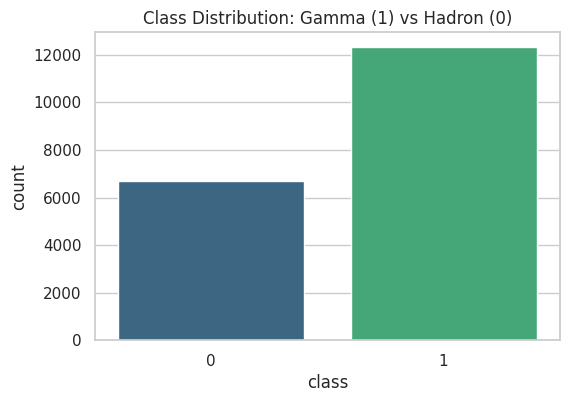

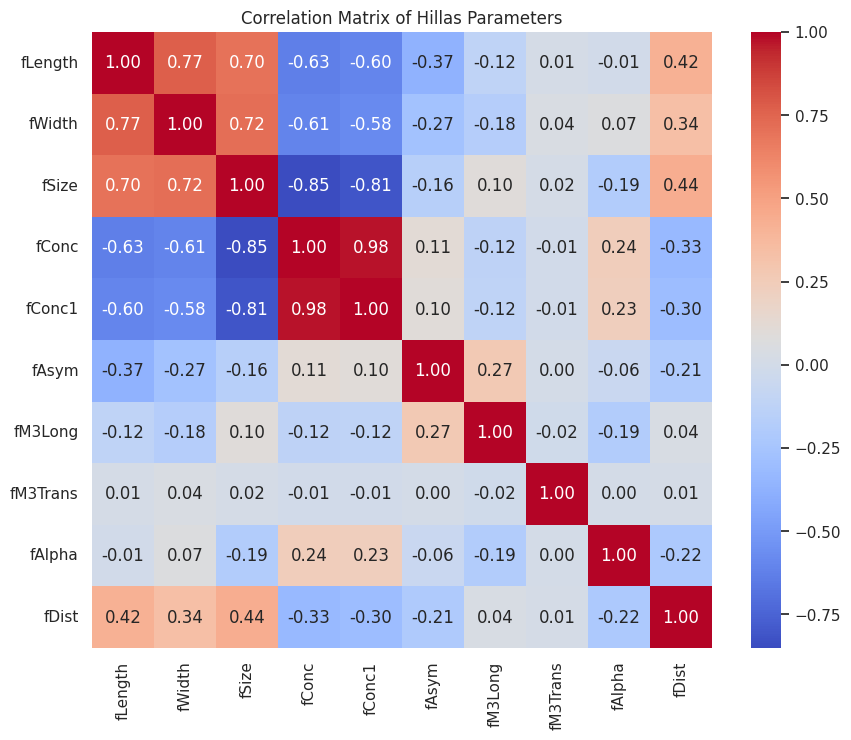

In [7]:
# --- 1. Data Loading ---
# Download dataset (your original code)
path = kagglehub.dataset_download("abhinand05/magic-gamma-telescope-dataset")
df = pd.read_csv(path + '/telescope_data.csv')
df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col]) # Removes unnecessary columns

# Mapping: g (signal) -> 1, h (background) -> 0
df['class'] = df['class'].map({'g': 1, 'h': 0})

FEATURES = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym','fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
LABEL = 'class'

# --- 2. Quick EDA ---
print("Dataset Shape:", df.shape)
print("\nClass Distribution (1=Gamma, 0=Hadron):")
print(df['class'].value_counts(normalize=True))

# Balance plot
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df, palette='viridis')
plt.title('Class Distribution: Gamma (1) vs Hadron (0)')
plt.show()

# Correlation Matrix (to see relationships between features)
plt.figure(figsize=(10, 8))
sns.heatmap(df[FEATURES].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Hillas Parameters')
plt.show()

In [8]:
X = df[FEATURES].values
y = df[LABEL].values

# First split: Separates the Test Set (20%) from the rest (80%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Second split: Separates Validation (20% of total) from Training (60% of total)
# Since X_train_val is 80% of the total, taking 25% of it gives us 20% total.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Training Shape: {X_train.shape} (60%)")
print(f"Validation Shape: {X_val.shape} (20%)")
print(f"Test Shape: {X_test.shape} (20%)")

# --- Scaling ---
# Important: Fit only on training, transform on val and test to avoid Data Leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_train_val_scaled = scaler.fit_transform(X_train_val) # For later

Training Shape: (11412, 10) (60%)
Validation Shape: (3804, 10) (20%)
Test Shape: (3804, 10) (20%)


In [4]:
# Dictionary of models to test
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gaussian NB": GaussianNB(),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)": SVC(probability=True, kernel='rbf'), # probability=True is needed for AUC
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results_baseline = []

print("Training Baselines...")
for name, model in models.items():
    start = time.time()

    # Training (Using scaled data for all for consistency, essential for SVM/KNN)
    model.fit(X_train_scaled, y_train)

    # Prediction on Validation
    y_pred = model.predict(X_val_scaled)
    y_proba = model.predict_proba(X_val_scaled)[:, 1] # Class 1 probability

    elapsed = time.time() - start

    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    results_baseline.append({
        "Model": name,
        "Val Accuracy": acc,
        "Val AUC": auc,
        "Time (s)": elapsed
    })
    print(f"Done: {name}")

# Create results DataFrame
df_results = pd.DataFrame(results_baseline).sort_values(by="Val AUC", ascending=False)
display(df_results)

Training Baselines...
Done: Logistic Regression
Done: Gaussian NB
Done: KNN (k=5)
Done: SVM (RBF)
Done: Random Forest


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:31:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done: XGBoost


,Model,Val Accuracy,Val AUC,Time (s)
4,Random Forest,0.882755,0.935298,6.707841
5,XGBoost,0.887750,0.934518,1.040508
3,SVM (RBF),0.871188,0.914995,30.070428
2,KNN (k=5),0.827813,0.870924,2.860371
0,Logistic Regression,0.788644,0.841055,0.327214
1,Gaussian NB,0.717928,0.751617,0.085735


--- Tuning SPORF ---
Testing SPORF: n_est=100, proj=RerF... AUC: 0.9339 (7.03s)
Testing SPORF: n_est=100, proj=RerF... AUC: 0.9339 (9.07s)
Testing SPORF: n_est=100, proj=Base... AUC: 0.9360 (6.33s)
Testing SPORF: n_est=100, proj=Base... AUC: 0.9360 (7.60s)
Testing SPORF: n_est=200, proj=RerF... AUC: 0.9351 (12.30s)
Testing SPORF: n_est=200, proj=RerF... AUC: 0.9351 (6.42s)
Testing SPORF: n_est=200, proj=Base... AUC: 0.9362 (6.95s)
Testing SPORF: n_est=200, proj=Base... AUC: 0.9362 (5.67s)

Best SPORF parameters found: {'n_estimators': 200, 'projection_matrix': 'Base', 'max_features': 3} with AUC: 0.9362


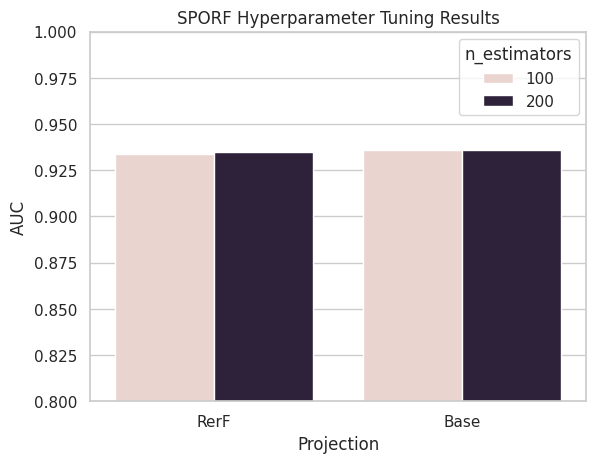

In [9]:
print("--- Tuning SPORF ---")

# Parameters to test
n_estimators_list = [100, 200]
projection_matrices = ['RerF', 'Base'] # RerF is SPORF (oblique splits), Base is classic Random Forest
max_features_list = ['auto', 'sqrt']

best_auc = 0
best_params = {}
sporf_results = []

for n_est in n_estimators_list:
    for proj in projection_matrices:
        for max_f in max_features_list:

            # Note: 'auto' in rerf sometimes gives warnings, 'sqrt' is safer
            if max_f == 'auto': max_f = int(np.sqrt(X.shape[1]))

            print(f"Testing SPORF: n_est={n_est}, proj={proj}...", end="")
            start = time.time()

            # Initialize SPORF
            clf = rerfClassifier(n_estimators=n_est, projection_matrix=proj, max_features=max_f, n_jobs=-1, random_state=42)

            clf.fit(X_train_scaled, y_train)

            # RerF predict_proba returns probabilities
            y_proba = clf.predict_proba(X_val_scaled)[:, 1]
            auc = roc_auc_score(y_val, y_proba)

            elapsed = time.time() - start
            print(f" AUC: {auc:.4f} ({elapsed:.2f}s)")

            sporf_results.append([n_est, proj, max_f, auc])

            if auc > best_auc:
                best_auc = auc
                best_params = {'n_estimators': n_est, 'projection_matrix': proj, 'max_features': max_f}

print(f"\nBest SPORF parameters found: {best_params} with AUC: {best_auc:.4f}")

# Tuning Visualization
df_sporf = pd.DataFrame(sporf_results, columns=['n_estimators', 'Projection', 'max_features', 'AUC'])
sns.barplot(x='Projection', y='AUC', hue='n_estimators', data=df_sporf)
plt.title("SPORF Hyperparameter Tuning Results")
plt.ylim(0.8, 1.0) # Zoom on the upper part
plt.show()

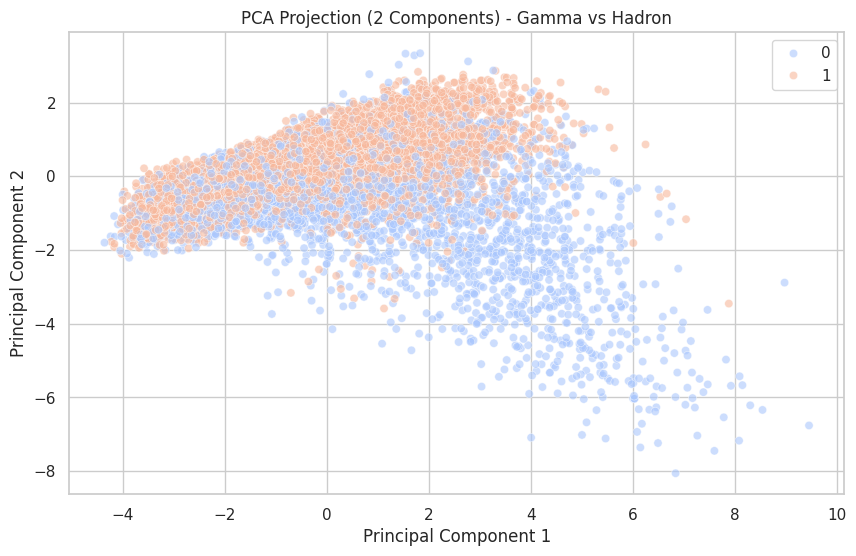

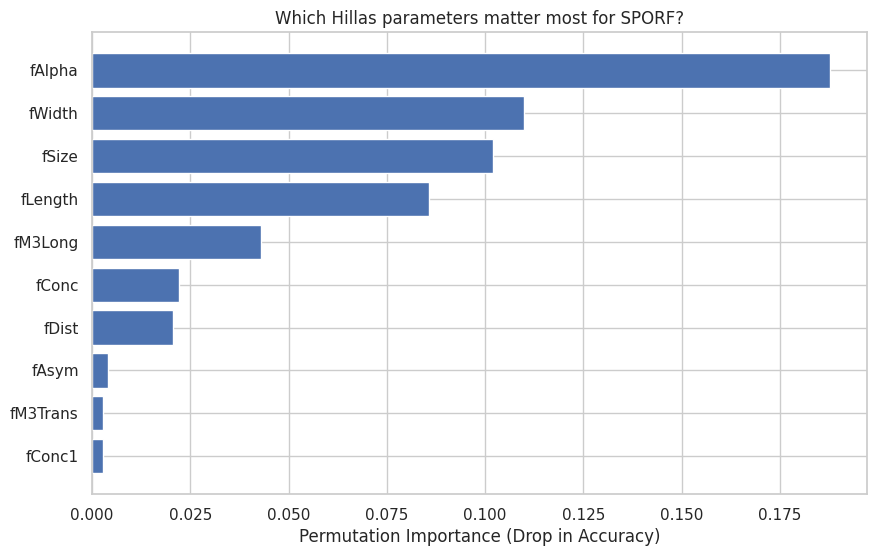

In [10]:
# --- 1. PCA Visualization ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='coolwarm', alpha=0.6)
plt.title('PCA Projection (2 Components) - Gamma vs Hadron')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# --- 2. Feature Importance (Permutation) ---
# Using the best SPORF model found
best_sporf = rerfClassifier(**best_params, random_state=42)
best_sporf.fit(X_train_scaled, y_train)

result_perm = permutation_importance(best_sporf, X_val_scaled, y_val, n_repeats=10, random_state=42)
sorted_idx = result_perm.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), result_perm.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [FEATURES[i] for i in sorted_idx])
plt.xlabel("Permutation Importance (Drop in Accuracy)")
plt.title("Which Hillas parameters matter most for SPORF?")
plt.show()

--- Executing LDA Experiment ---


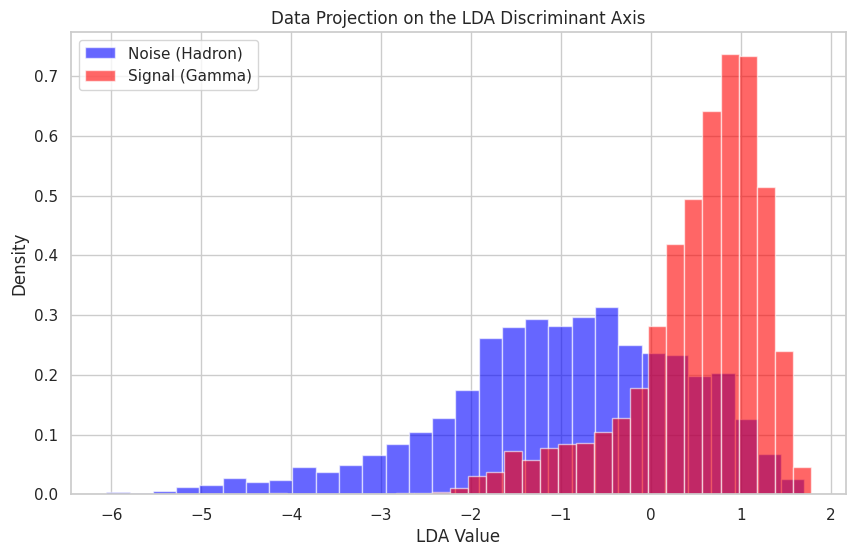

If you see two well-separated 'mountains' (red and blue), LDA has found an excellent discriminant axis!


In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

print("--- Executing LDA Experiment ---")

# 1. LDA Application
# LDA reduces to (n_classes - 1) dimensions. Here we have 2 classes -> 1 dimension.
lda = LinearDiscriminantAnalysis(n_components=1)

# Fit only on the scaled training set
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled) # We also transform the test set for later

# 2. Separation Visualization
# We create a histogram to see if the two classes have separated
plt.figure(figsize=(10, 6))
plt.hist(X_train_lda[y_train==0], bins=30, alpha=0.6, label='Noise (Hadron)', color='blue', density=True)
plt.hist(X_train_lda[y_train==1], bins=30, alpha=0.6, label='Signal (Gamma)', color='red', density=True)
plt.title("Data Projection on the LDA Discriminant Axis")
plt.xlabel("LDA Value")
plt.ylabel("Density")
plt.legend()
plt.show()

print("If you see two well-separated 'mountains' (red and blue), LDA has found an excellent discriminant axis!")

In [15]:
from sklearn.metrics import roc_auc_score

# Define a custom scoring function
def custom_roc_auc_scorer(estimator, X, y):
    y_proba = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_proba)

# 1. Robust Cross Validation (on combined Train+Val)
print("Performing 5-fold Cross-Validation on Train+Val...")
# Setting n_jobs=1 to avoid ModuleNotFoundError when pickling rerfClassifier to child processes.
cv_scores = cross_val_score(best_sporf, X_train_val_scaled, y_train_val, cv=5, scoring=custom_roc_auc_scorer, n_jobs=1)
print(f"Cross-Validation AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# 2. Final Training and Test
print("\nFinal training of optimal SPORF model...")
start_final = time.time()
best_sporf.fit(X_train_val_scaled, y_train_val) # Train on 80% data
y_test_pred = best_sporf.predict(X_test_scaled)
y_test_proba = best_sporf.predict_proba(X_test_scaled)[:, 1]
time_final = time.time() - start_final

print(f"Test Set AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Test Set Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Performing 5-fold Cross-Validation on Train+Val...
Cross-Validation AUC: 0.9337 (+/- 0.0043)

Final training of optimal SPORF model...
Test Set AUC: 0.9400
Test Set Accuracy: 0.8854


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:39:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


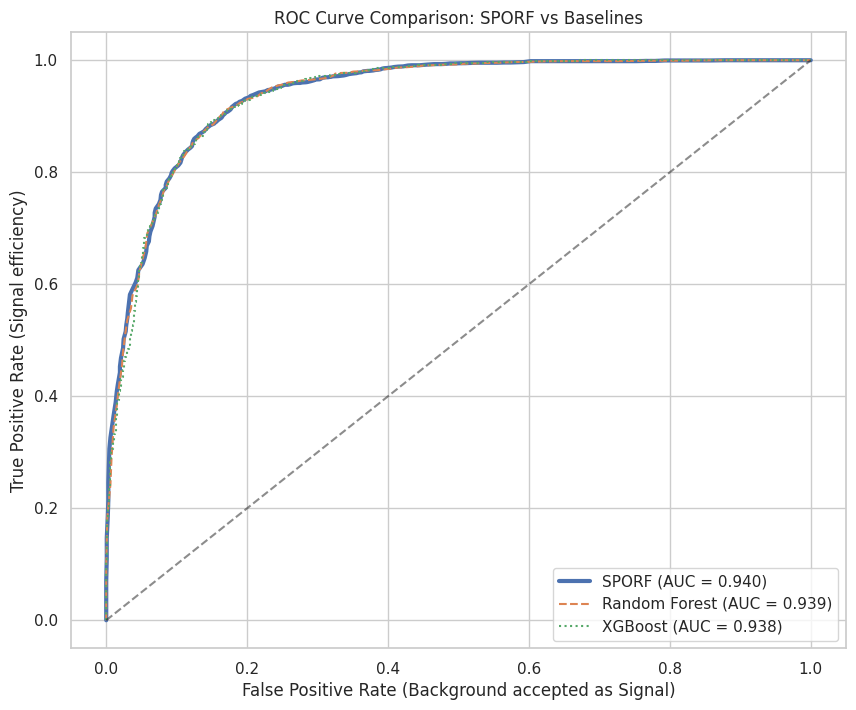


--- Confusion Matrix (High Threshold: 0.8) ---
Note how False Positives (top right) decrease as the threshold increases.


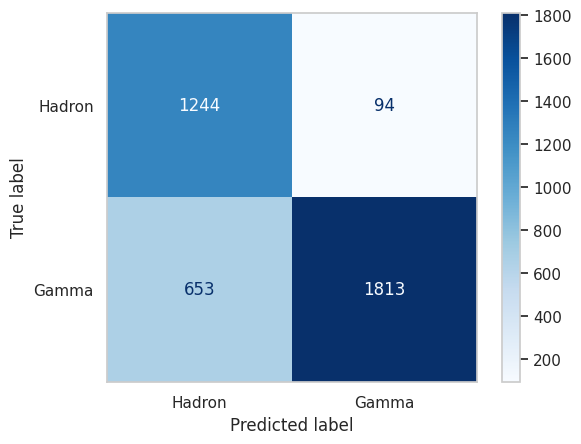

              precision    recall  f1-score   support

      Hadron       0.66      0.93      0.77      1338
       Gamma       0.95      0.74      0.83      2466

    accuracy                           0.80      3804
   macro avg       0.80      0.83      0.80      3804
weighted avg       0.85      0.80      0.81      3804



In [16]:
# --- 1. ROC Curve Comparison ---
plt.figure(figsize=(10, 8))

# SPORF ROC
fpr_sporf, tpr_sporf, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr_sporf, tpr_sporf, label=f"SPORF (AUC = {roc_auc_score(y_test, y_test_proba):.3f})", linewidth=3)

# Random Forest ROC (retrain on train+val for fair comparison)
rf_final = RandomForestClassifier(n_estimators=100).fit(X_train_val_scaled, y_train_val)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_final.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr_rf, tpr_rf, linestyle='--', label=f"Random Forest (AUC = {roc_auc_score(y_test, rf_final.predict_proba(X_test_scaled)[:, 1]):.3f})")

# XGBoost ROC
xgb_final = XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X_train_val_scaled, y_train_val)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_final.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr_xgb, tpr_xgb, linestyle=':', label=f"XGBoost (AUC = {roc_auc_score(y_test, xgb_final.predict_proba(X_test_scaled)[:, 1]):.3f})")

# Random line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)

plt.xlabel('False Positive Rate (Background accepted as Signal)')
plt.ylabel('True Positive Rate (Signal efficiency)')
plt.title('ROC Curve Comparison: SPORF vs Baselines')
plt.legend(loc="lower right")
plt.show()

# --- 2. Confusion Matrix with Conservative Threshold ---
# For the MAGIC telescope, we want FEW false positives.
# We set a high threshold: Accept as Gamma only if prob > 80%
threshold = 0.8
y_pred_conservative = (y_test_proba >= threshold).astype(int) # y_test_proba is from SPORF

cm = confusion_matrix(y_test, y_pred_conservative)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Hadron', 'Gamma'])

print(f"\n--- Confusion Matrix (High Threshold: {threshold}) ---")
print("Note how False Positives (top right) decrease as the threshold increases.")
disp.plot(cmap='Blues')
plt.grid(False)
plt.show()

print(classification_report(y_test, y_pred_conservative, target_names=['Hadron', 'Gamma']))

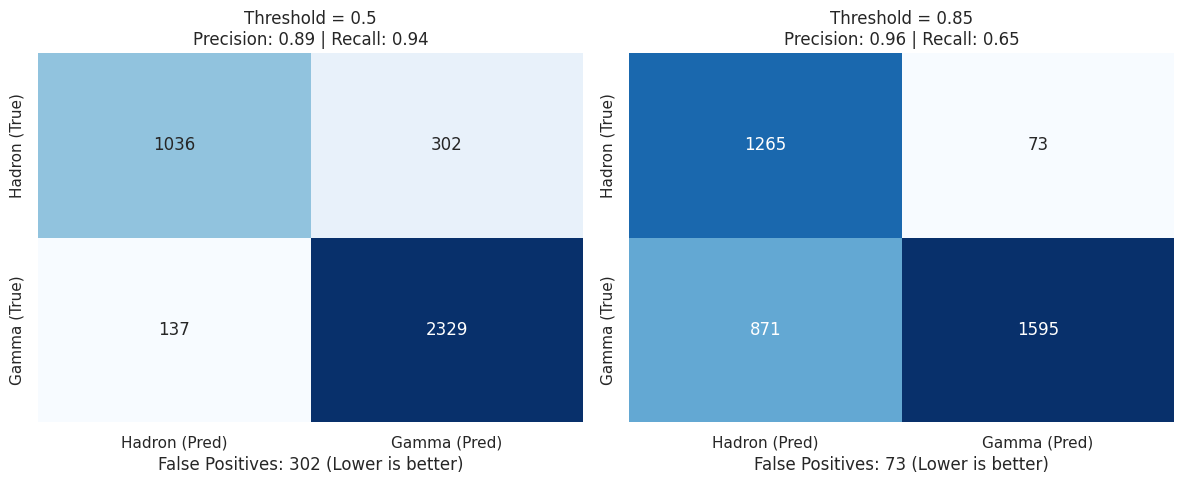

In [17]:
from sklearn.metrics import precision_score, recall_score

# --- Threshold Analysis (False Positive Management) ---

# Predicted probabilities on the test set
y_proba_test = best_sporf.predict_proba(X_test_scaled)[:, 1]

# We define two thresholds: Standard (0.5) and Conservative (e.g., 0.85)
thresholds = [0.5, 0.85]

plt.figure(figsize=(12, 5))

for i, thresh in enumerate(thresholds):
    # Create predictions based on the threshold
    y_pred_custom = (y_proba_test >= thresh).astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred_custom)

    # Specific metrics
    prec = precision_score(y_test, y_pred_custom)
    rec = recall_score(y_test, y_pred_custom)

    # Plot
    plt.subplot(1, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Hadron (Pred)', 'Gamma (Pred)'],
                yticklabels=['Hadron (True)', 'Gamma (True)'])
    plt.title(f"Threshold = {thresh}\nPrecision: {prec:.2f} | Recall: {rec:.2f}")

    # Highlight the critical number: False Positives (Top Right)
    fp_count = cm[0, 1]
    plt.xlabel(f"False Positives: {fp_count} (Lower is better)")

plt.tight_layout()
plt.show()

In [18]:
# Remove the 3 worst features from your plot
features_to_drop = ['fConc1', 'fM3Trans', 'fAsym']
features_selected = [f for f in FEATURES if f not in features_to_drop]

print(f"Training SPORF with only the best features: {features_selected}")

# You need to re-subset the columns
idx_keep = [FEATURES.index(f) for f in features_selected]
X_train_sel = X_train_scaled[:, idx_keep]
X_test_sel = X_test_scaled[:, idx_keep]

# Quick test
clf_sel = rerfClassifier(**best_params, random_state=42, n_jobs=1)
clf_sel.fit(X_train_sel, y_train)
print("New Accuracy (Feature Selection):", clf_sel.score(X_test_sel, y_test))

Training SPORF with only the best features: ['fLength', 'fWidth', 'fSize', 'fConc', 'fM3Long', 'fAlpha', 'fDist']
New Accuracy (Feature Selection): 0.8796004206098843


Training and evaluating Logistic Regression for ROC plot...
Training and evaluating Gaussian NB for ROC plot...
Training and evaluating KNN (k=5) for ROC plot...
Training and evaluating SVM (RBF) for ROC plot...
Training and evaluating Random Forest for ROC plot...
Training and evaluating XGBoost for ROC plot...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:41:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


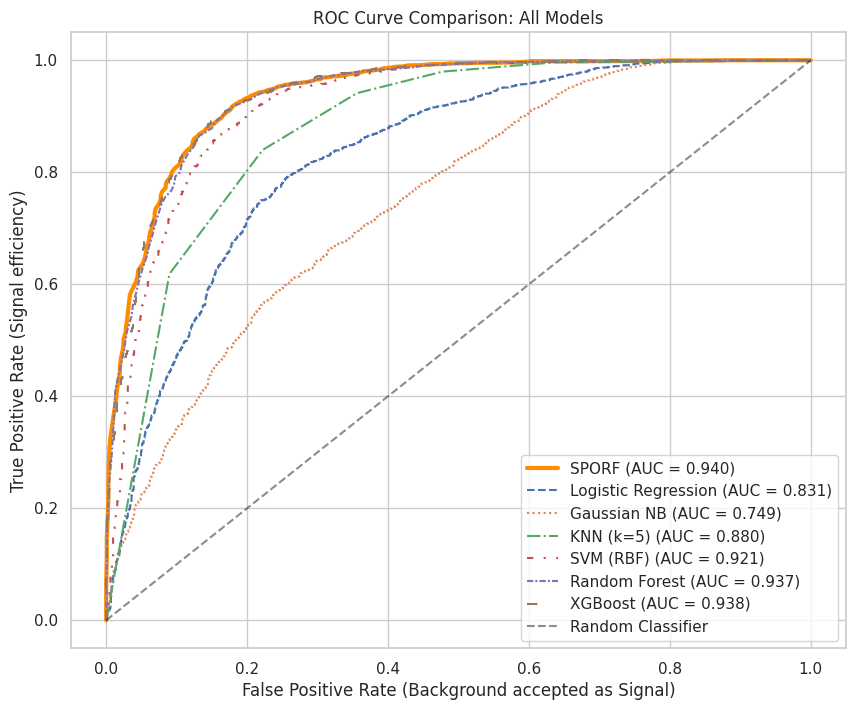


--- Confusion Matrix (High Threshold: 0.8) ---
Note how False Positives (top right) decrease as the threshold increases.


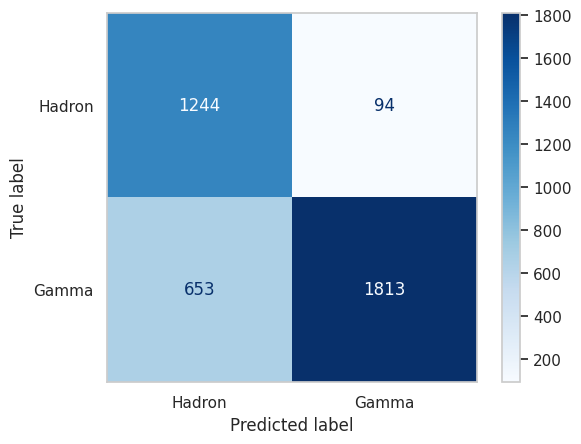

              precision    recall  f1-score   support

      Hadron       0.66      0.93      0.77      1338
       Gamma       0.95      0.74      0.83      2466

    accuracy                           0.80      3804
   macro avg       0.80      0.83      0.80      3804
weighted avg       0.85      0.80      0.81      3804



In [19]:
# --- 1. ROC Curve Comparison ---
plt.figure(figsize=(10, 8))

# Plot SPORF ROC (already trained and probabilities available from a previous cell)
fpr_sporf, tpr_sporf, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr_sporf, tpr_sporf, label=f"SPORF (AUC = {roc_auc_score(y_test, y_test_proba):.3f})", linewidth=3, color='darkorange') # Using a distinct color

# Define linestyles to cycle through for better visual distinction
linestyles = ['--', ':', '-.', (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (5, 10))]
style_idx = 0

# Loop through all models in the dictionary, train them on the combined data, and plot their ROC curves
for name, model_instance in models.items():
    print(f"Training and evaluating {name} for ROC plot...")

    # Train on combined train+validation set
    model_instance.fit(X_train_val_scaled, y_train_val)

    # Predict probabilities on the test set
    y_proba_model = model_instance.predict_proba(X_test_scaled)[:, 1]

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba_model)
    auc_score = roc_auc_score(y_test, y_proba_model)

    # Plot the ROC curve, cycling through linestyles
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})", linestyle=linestyles[style_idx % len(linestyles)])
    style_idx += 1

# Plot the random classifier line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

plt.xlabel('False Positive Rate (Background accepted as Signal)')
plt.ylabel('True Positive Rate (Signal efficiency)')
plt.title('ROC Curve Comparison: All Models')
plt.legend(loc="lower right")
plt.show()

# --- 2. Confusion Matrix with Conservative Threshold ---
# For the MAGIC telescope, we want FEW false positives.
# We set a high threshold: Accept as Gamma only if prob > 80%
threshold = 0.8
y_pred_conservative = (y_test_proba >= threshold).astype(int) # y_test_proba is from SPORF

cm = confusion_matrix(y_test, y_pred_conservative)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Hadron', 'Gamma'])

print(f"\n--- Confusion Matrix (High Threshold: {threshold}) ---")
print("Note how False Positives (top right) decrease as the threshold increases.")
disp.plot(cmap='Blues')
plt.grid(False)
plt.show()

print(classification_report(y_test, y_pred_conservative, target_names=['Hadron', 'Gamma']))